## 一次元畳み込み
畳み込み( Convolution ) を使ったニューラルネットワーク ( CNN ) は、今や機械学習の代名詞のようなものですが、CNNといった場合は、暗黙のうちに二次元、つまり画像データに畳み込みフィルターを使ったものを指しているように思います。  

2次元畳み込みフィルターは、実際には画像の特徴を表す何らかのパターンを抽出しているということですが、1次元の時系列データ、要するにグラフですが、こいつの中にパターンを見つけ、時系列データの特徴を捉えてしまおうというのが1次元畳み込みフィルターです。

In [1]:
# ライブラリーのインポート
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers.convolutional import Conv1D, UpSampling1D
from keras.layers.pooling import MaxPooling1D
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

Using TensorFlow backend.


C:\ProgramData\Anaconda3\envs\AI\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\AI\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\AI\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\envs\AI\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\envs\AI\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\AI\lib\site-packages\matplotlib\backends\backend_agg.py:211

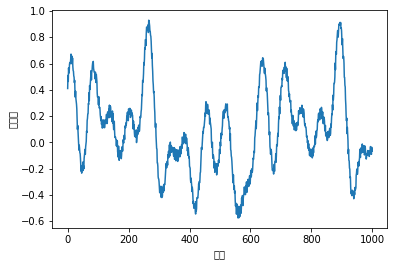

In [2]:
# データの準備
timeline = np.arange(10000)
epochs = 100

# サインデータ生成関数
def sinnp(n, line):
    return np.sin(line * n / 100)

# コサインデータ生成関数
def cosnp(n, line):
    return np.cos(line * n / 100)

# サンプルデータの生成
raw_data = (sinnp(1, timeline) + sinnp(3, timeline) + sinnp(10, timeline) + cosnp(5, timeline) + cosnp(7, timeline)) / 5
# ノイズ処理
raw_data = raw_data + (np.random.rand(len(timeline)) * 0.1)# ノイズ項
# 描画
plt.plot(timeline[:1000], raw_data[:1000])
plt.xlabel("時間")
plt.ylabel("測定値")
plt.show()

これで今回の実験に使うデータは作成完了です。
ここで、わざわざノイズ項をいれていますが、意図的にノイズを入れておいたほうが、結果が良くなるので入れてたりします。

次に、実験における入力と出力を決める必要があります。  
今回はこれくらいなら実用性がありそう、という目論見を持って、

「連続した64個の時系列データを元に、次の16個の時系列データを生成する」

と言う機械を作りましょう。  
すると、入力と出力は次のように形成すると良いと思います。

In [3]:
raw_data.shape

(10000,)

In [4]:
input_data = []
output_data = []
for n in range(10000-80):
    input_data.append(raw_data[n:n+64])
    output_data.append(raw_data[n+64:n+80])

input_data = np.array(input_data)
output_data = np.array(output_data)
print(input_data.shape)
print(output_data.shape)

(9920, 64)
(9920, 16)


入力と出力のデータが作れましたが、これではまだ十分ではあありません。  
一次元畳み込みでは、データの形状に注意する必要があります。  
一次元畳み込みそうにおける入力の形状(shape)は(<シーケンス長>, <パラメータ数>)となっていなければなりません。  
今回、グラフを作るためのパラメータの個数、つまり、f(t)f(t)は一次元なので、パラメータ数は1となります。  
シーケンス長はサンプルとして取ってくる連続したデータ点の個数となりますので、今回は64となります。  

ということで、入力データをちゃんと扱える形に整形します。

In [5]:
train_X = np.reshape(input_data, (-1, 64, 1))
train_Y = np.reshape(output_data, (-1, 16, 1))
print(train_X.shape)
print(train_Y.shape)

(9920, 64, 1)
(9920, 16, 1)


## 学習器を作る
それでは、学習器を構成する層を積んでみましょう。

In [6]:
model = Sequential()
model.add(Conv1D(64, 8, padding='same', input_shape=(64, 1), activation='relu'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(64, 8, padding='same', activation='relu'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(32, 8, padding='same', activation='relu'))
model.add(Conv1D(1, 8, padding='same', activation='tanh'))

model.compile(loss='mse', optimizer='adam')

ここでConv1D(filters, kernel_size)が一次元畳み込みを表すそうになります。  
Conv1Dの出力層のshapeは (<シーケンス長>, filters)となります。  
なので、一番はじめの層を見ると、先に設定した入力は
(64, 1) -> (64, 64)というshapeになることがわかります。  
また、MaxPooling1Dを使用することで、シーケンス長の部分の次元削減を行います。  
最後の層が出力層ですが、ここで今回予測したい出力と次元があうようにしています。  

積んだ層がどのようになっているかはsummaryを出すことで確認できます。

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 64, 64)            576       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            32832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 32)            16416     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 16, 1)             257       
Total params: 50,081
Trainable params: 50,081
Non-trainable params: 0
__________________________________________________

最後の層の出力が期待値として設定した出力の形状と同じなので、今回は全結合しなくて良い感じです。  
それでは学習を開始しましょう。

In [8]:
# Early-stopping
early_stopping = EarlyStopping(patience=0, verbose=1)
history = model.fit(train_X, train_Y, validation_split=0.1, epochs=epochs,callbacks=[early_stopping])

Train on 8928 samples, validate on 992 samples
Epoch 1/100
8928/8928 [==============================] - 2s 222us/step - loss: 0.0317 - val_loss: 0.0097
Epoch 2/100
8928/8928 [==============================] - 2s 207us/step - loss: 0.0073 - val_loss: 0.0083
Epoch 3/100
8928/8928 [==============================] - 2s 204us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 4/100
8928/8928 [==============================] - 2s 204us/step - loss: 0.0048 - val_loss: 0.0043
Epoch 5/100
8928/8928 [==============================] - 2s 198us/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/100
8928/8928 [==============================] - 2s 198us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 7/100
8928/8928 [==============================] - 2s 199us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 8/100
8928/8928 [==============================] - 2s 198us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/100
8928/8928 [==============================] - 2s 202us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10

全データの内、10%をテストデータとして確保することにしました。
また、学習過程をhistoryに保存しているので、こいつを表示して学習の収束具合を調べてみましょう。

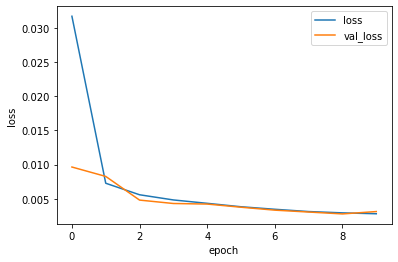

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.show()

## 学習器を使用してみる
学習しただけでは意味がありませんので、軽く使用してみましょう。  
今回作ったのは、前の64点から次の16点を導き出す機械ですので、はじめに64点のサンプルを取り出し、それを使って16点を生成したら、その16点を新たにサンプルに加えて、次の16点を生成する・・・を繰り返すジェネレータを作ってみましょう。  
今回は20回分、320点先まで予測させてみましょう。

In [12]:
start = 9100
sheed = np.reshape(raw_data[start:start+64], (1, 64, 1))
prediction = sheed

for i in range(20):
    res = model.predict(sheed)
    sheed = np.concatenate((sheed[:, 16:, :], res), axis=1)
    prediction = np.concatenate((prediction, res), axis=1)

次に、予測結果predictionと元のデータを比較しましょう。  
グラフに書き出しやすいように、少々データを整形しています。

(1, 384, 1)
(384,)


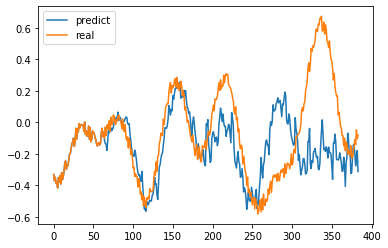

In [13]:
print(prediction.shape)
predictor = np.reshape(prediction, (-1))
print(predictor.shape)
plt.plot(range(len(predictor)), predictor, label='predict')
plt.plot(range(len(predictor)), raw_data[start:start + len(predictor)], label='real')
plt.legend() 
plt.show()

250点前後で、元データとの乖離が激しくなってきていますが、逆を返せば、10回分程度の先読みが
成功していると言ってもいいのではないかと思います。